# Setup

In [38]:
from typing import Dict, Tuple
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image



## hyperparameters


In [39]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/'

# training hyperparameters
batch_size = 100
n_epoch = 40
lrate=1e-3

## Sprites Dataset

In [40]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2025-01-26 11:58:10--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.61, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1737896290&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzg5NjI5MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJiZj

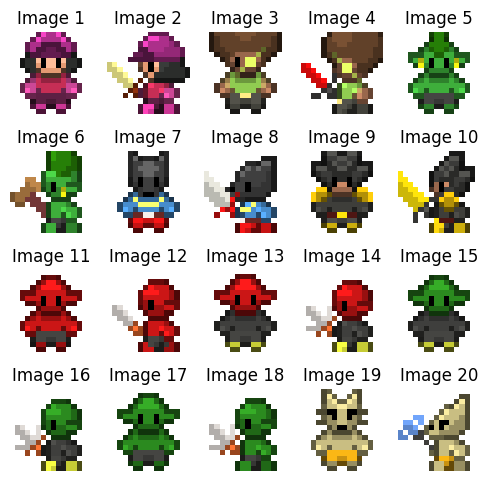

In [41]:
sprites_samples = np.load("sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [43]:
sprites = np.load("sprites_1788_16x16.npy")
slabels = np.load("sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [44]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

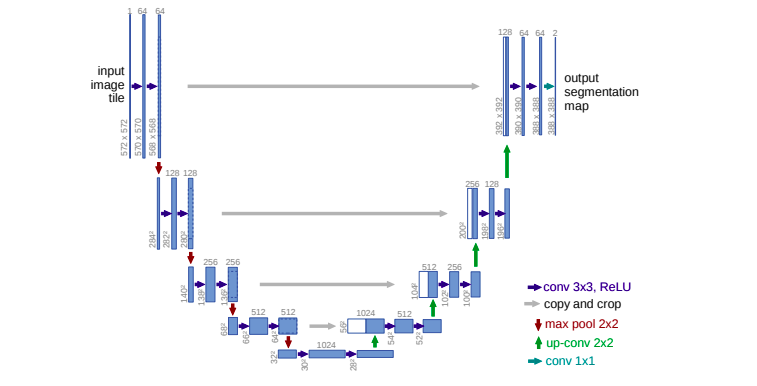

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [45]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_res=False):
        super().__init__()
        self.is_res = is_res
        self.same_channels = (in_channels == out_channels)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        
        # Define a shortcut conv if channels differ AND we need residual
        if is_res and not self.same_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut_conv = None

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)

        if self.is_res:
            if self.same_channels:
                out = x + x2
            else:
                # Use the pre-defined 1x1 conv
                out = self.shortcut_conv(x) + x2
            return out / 1.414
        else:
            return x2


    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [47]:
# construct model
# TODO
nn_model = Unet(
    in_channels=3,          
    n_feat=n_feat,          
    n_cfeat=n_cfeat,        
    height=height           
).to(device)



In [48]:
#construct optimizer
# TODO
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)


We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [49]:
# TODO: complete the code here
# Create Linear Scheduler - beta1 and beta2 are given in the hypermarapeters block
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timesteps = 1000
beta1, beta2 = 1e-4, 0.02

betas = torch.linspace(beta1, beta2, timesteps, device=device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)  # (timesteps,) on device



### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [50]:
def perturb_input(x0, t):
    """
    x0: (B, 3, 16, 16) on device
    t:  (B,) torch.long on device in [0..timesteps-1]
    """
    # Gather alpha_bar[t] => shape (B,)
    alpha_bar_t = alpha_bar[t]                  # shape (B,)
    alpha_bar_t = alpha_bar_t.view(-1,1,1,1)    # broadcast to (B,1,1,1)

    # Same device as x0
    noise = torch.randn_like(x0)
    
    # x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * noise
    x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise
    return x_t, noise

### Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

In [ ]:
train_losses = []
val_losses = []

for epoch in range(1, n_epoch + 1):
    nn_model.train()
    total_train_loss = 0.0
    train_batch_count = 0

    for batch_idx, (images, c) in enumerate(train_dataloader, 1):
        try:
            images = images.to(device)          # shape (B,3,16,16)
            c = c.float().to(device)            # shape (B,5)

            # 1) Random time steps in [0..timesteps-1]
            t = torch.randint(0, timesteps, (images.size(0),), device=device, dtype=torch.long)

            # 2) Get noised images and the actual noise
            noised_images, real_noise = perturb_input(images, t)

            # 3) Convert t to float for model's time embedding
            t_embed = t.float().unsqueeze(-1)  # shape (B,1)

            # 4) Forward pass to predict the noise
            predicted_noise = nn_model(noised_images, t_embed, c)  # shape (B,3,16,16)

            # 5) Compute MSE loss
            loss = F.mse_loss(predicted_noise, real_noise)

            # 6) Backpropagation and optimization
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Accumulate training loss
            total_train_loss += loss.item()
            train_batch_count += 1

            # Free up memory
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("Out of memory! Skipping batch...")
                torch.cuda.empty_cache()
            else:
                raise e

    avg_train_loss = total_train_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    nn_model.eval()
    total_val_loss = 0.0
    val_batch_count = 0

    with torch.no_grad():
        for val_batch_idx, (val_images, val_c) in enumerate(val_dataloader, 1):
            # Move data to device
            val_images = val_images.to(device)          # shape (B,3,16,16)
            val_c = val_c.float().to(device)            # shape (B,5)

            # 1) Random time steps in [0..timesteps-1]
            t_val = torch.randint(0, timesteps, (val_images.size(0),), device=device, dtype=torch.long)

            # 2) Get noised images and the actual noise
            noised_val_images, real_val_noise = perturb_input(val_images, t_val)

            # 3) Convert t to float for model's time embedding
            t_val_embed = t_val.float().unsqueeze(-1)  # shape (B,1)

            # 4) Forward pass to predict the noise
            predicted_val_noise = nn_model(noised_val_images, t_val_embed, val_c)  # shape (B,3,16,16)

            # 5) Compute MSE loss
            val_loss = F.mse_loss(predicted_val_noise, real_val_noise)

            # Accumulate validation loss
            total_val_loss += val_loss.item()
            val_batch_count += 1

    # Calculate average validation loss for the epoch
    avg_val_loss = total_val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch}/{n_epoch}], Train Avg Loss: {avg_train_loss:.6f}, Val Avg Loss: {avg_val_loss:.6f}")

# Save the final model after all epochs
final_model_path = "model_final.pth"
torch.save(nn_model.state_dict(), final_model_path)
print(f"Final model saved: {final_model_path}")



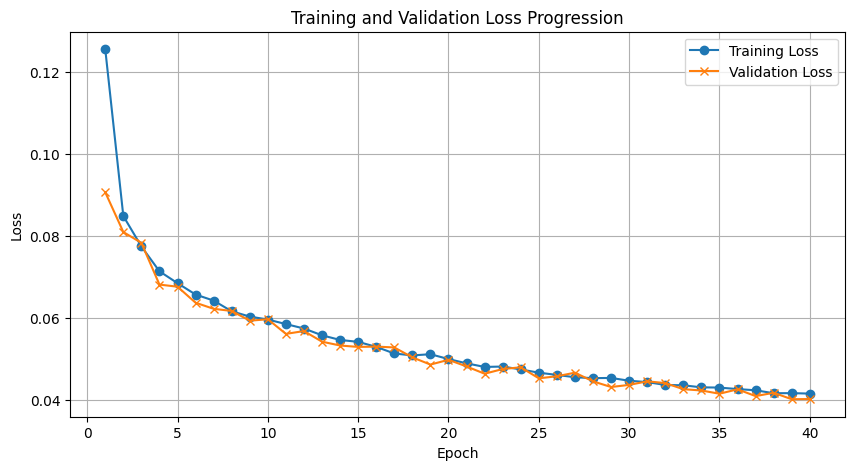

In [52]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epoch + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, n_epoch + 1), val_losses, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Progression")
plt.legend()
plt.grid(True)
plt.show()


## Reverse process: DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm

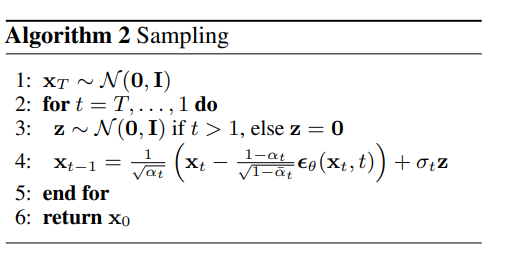

In [78]:
def p_xt_ddpm(current_noise_image, predicted_noise, time_step):
    """
    Performs one denoising step in DDPM to obtain x_{t-1} from x_t.
    
    Args:
        current_noise_image (torch.Tensor): Current noised image at time step t, 
            shape (B, C, H, W).
        predicted_noise (torch.Tensor): Noise predicted by the model, shape (B, C, H, W).
        time_step (torch.Tensor): Current time step indices, shape (B,). Each entry in 
            [0..timesteps-1].
    
    Returns:
        torch.Tensor: The denoised image at time step t-1, shape (B, C, H, W).
    """
    # Gather alpha_t, alpha_bar_t, and beta_t for this batch of time steps
    alpha_t      = alphas[time_step].view(-1, 1, 1, 1)      # (B,1,1,1)
    alpha_bar_t  = alpha_bar[time_step].view(-1, 1, 1, 1)   # (B,1,1,1)
    beta_t       = betas[time_step].view(-1, 1, 1, 1)       # (B,1,1,1)

    # DDPM uses sigma = sqrt(beta_t)
    sigma_t = torch.sqrt(beta_t)

    # === Compute the mean ===
    # mean = 1/sqrt(alpha_t) * [ x_t - (1 - alpha_t)/sqrt(1 - alpha_bar_t) * predicted_noise]
    mean = (1.0 / torch.sqrt(alpha_t)) * (
        current_noise_image - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * predicted_noise
    )

    # Sample z ~ N(0, I) if t > 0, else z = 0 (i.e., no noise at t=0)
    # If we look at time_step[0], that implies all in the batch have the same t. 
    z = torch.randn_like(current_noise_image)
    mask_nonzero_t = (time_step != 0).float().view(-1,1,1,1)
    z = z * mask_nonzero_t  # zero out noise for t=0

    # === Compute x_{t-1} ===
    x_prev = mean + sigma_t * z
    return x_prev


def p_xt_ddim(current_noise_image, predicted_noise, time_step, eta=0.0):
    """
    Performs one denoising step in DDIM to obtain x_{t-1} from x_t.
    
    Args:
        current_noise_image (torch.Tensor): Current noised image at time step t, 
            shape (B, C, H, W).
        predicted_noise (torch.Tensor): Noise predicted by the model, shape (B, C, H, W).
        time_step (torch.Tensor or int): Current time step indices, shape (B,). 
            If int, we broadcast to the entire batch. 
        eta (float): Controls the level of noise in DDIM (0 = deterministic).
    
    Returns:
        torch.Tensor: The denoised image at time step t-1, shape (B, C, H, W).
    """
    device = current_noise_image.device

    # Handle scalar or tensor time_step
    if isinstance(time_step, int):
        time_step = torch.tensor([time_step]*current_noise_image.size(0), 
                                 device=device, dtype=torch.long)
    else:
        time_step = time_step.to(device).long()

    # If t=0, we don't go further
    if (time_step == 0).all():
        return current_noise_image

    # Gather relevant values
    alpha_t      = alphas[time_step].view(-1,1,1,1)
    alpha_bar_t  = alpha_bar[time_step].view(-1,1,1,1)
    alpha_bar_tm1 = alpha_bar[torch.clamp(time_step-1,0)].view(-1,1,1,1)
    beta_t       = betas[time_step].view(-1,1,1,1)

    # DDIM formula:
    # sigma_t = eta * sqrt( (1 - alpha_bar_{t-1})/(1 - alpha_bar_t) * beta_t )
    sigma_t = eta * torch.sqrt(beta_t * (1.0 - alpha_bar_tm1)/(1.0 - alpha_bar_t))

    # mean = sqrt(alpha_bar_{t-1}/alpha_bar_t) * [ x_t 
    #          - sqrt(1 - alpha_bar_t - for the unconditional) 
    #          - or more precisely: (1 - alpha_t)/sqrt(1 - alpha_bar_t) * predicted_noise]
    #        Here, (1 - alpha_t) = beta_t
    mean = (
        torch.sqrt(alpha_bar_tm1 / alpha_bar_t) *
        (current_noise_image - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * predicted_noise)
    )

    # z ~ N(0, I) if we want non-deterministic sampling (eta>0), else 0
    z = torch.randn_like(current_noise_image) if eta > 0.0 else torch.zeros_like(current_noise_image)

    # x_{t-1} = mean + sigma_t * z
    x_prev = mean + sigma_t * z
    return x_prev


## Reverse process: DDIM Sampling

Study the DDIM sampling method for reverse process and like the previous part, Implement this process regarding the DDIM method.

In [79]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.no_grad()
def generate_samples_ddpm(model, batch_size=20, c=None, num_steps=1000, 
                          return_frames=True):
    """
    Runs the reverse process for DDPM sampling.
    
    Args:
        model (nn.Module): Your trained U-Net (or similar) diffusion model.
        batch_size (int): Number of samples to generate.
        c (torch.Tensor or None): Context tensor of shape (B, n_cfeat), 
            or None for unconditional.
        num_steps (int): The total number of diffusion steps (T).
        return_frames (bool): Whether to return intermediate frames 
            to visualize the trajectory.
            
    Returns:
        final_images: shape (B, 3, 16, 16) final sampled images.
        frames (optional): list of intermediate images for visualization.
    """
    device = next(model.parameters()).device
    # Start from x_T ~ N(0, 1)
    x_t = torch.randn(batch_size, 3, height, height, device=device)
    
    frames = []
    for t in reversed(range(num_steps)):
        t_batch = torch.tensor([t]*batch_size, device=device, dtype=torch.long)
        t_embed = t_batch.float().unsqueeze(-1)
        
        # 1) Predict noise
        predicted_noise = model(x_t, t_embed, c)  # (B,3,H,W)
        # 2) One reverse step
        x_t = p_xt_ddpm(x_t, predicted_noise, t_batch)
        
        # Save intermediate frames if desired
        if return_frames and (t % (num_steps//5) == 0 or t<5):
            frames.append(x_t.detach().cpu())
    
    # Return the final images and optionally the frames
    if return_frames:
        return x_t, frames
    return x_t


@torch.no_grad()
def generate_samples_ddim(model, batch_size=20, c=None, num_steps=1000, 
                          eta=0.0, return_frames=True):
    """
    Runs the reverse process for DDIM sampling.
    
    Args:
        model (nn.Module): Your trained U-Net (or similar) diffusion model.
        batch_size (int): Number of samples to generate.
        c (torch.Tensor or None): Context tensor of shape (B, n_cfeat), 
            or None for unconditional.
        num_steps (int): The total number of diffusion steps (T).
        eta (float): Controls the level of stochasticity. 0 => deterministic.
        return_frames (bool): Whether to return intermediate frames 
            to visualize the trajectory.
            
    Returns:
        final_images: shape (B, 3, 16, 16) final sampled images.
        frames (optional): list of intermediate images for visualization.
    """
    device = next(model.parameters()).device
    x_t = torch.randn(batch_size, 3, height, height, device=device)
    
    frames = []
    for t in reversed(range(num_steps)):
        t_batch = torch.tensor([t]*batch_size, device=device, dtype=torch.long)
        t_embed = t_batch.float().unsqueeze(-1)
        
        predicted_noise = model(x_t, t_embed, c)
        x_t = p_xt_ddim(x_t, predicted_noise, t_batch, eta=eta)
        
        # Save intermediate frames if you want to see them
        if return_frames and (t % (num_steps//5) == 0 or t<5):
            frames.append(x_t.detach().cpu())
    
    if return_frames:
        return x_t, frames
    return x_t


## Results

In [80]:
def generate_images(model, num_images=20, method='ddpm', eta=0.0, save_dir='generated_images', device=device):
    """
    Generates images using the reverse diffusion process.

    Args:
        model (nn.Module): The trained denoising model.
        num_images (int): Number of images to generate.
        method (str): Sampling method - 'ddpm' or 'ddim'.
        eta (float): Controls the stochasticity for DDIM. Default is 0.0 (deterministic).
        save_dir (str): Directory to save the generated images.
        device (torch.device): Device to perform computations.

    Returns:
        None
    """
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for i in tqdm(range(num_images), desc=f"Generating {method.upper()} Images"):
            # 1. Sample x_T from N(0, I)
            x_t = torch.randn(1, 3, height, height).to(device)

            # 2. Iterate from T to 1
            for t in reversed(range(timesteps)):
                t_tensor = torch.tensor([t], device=device, dtype=torch.long)
                t_embed = torch.tensor([t], device=device, dtype=torch.float).unsqueeze(-1)

                # 3. Sample context if needed. Here we set it to zeros.
                c = torch.zeros(1, n_cfeat).to(device)

                # 4. Predict the noise using the model
                predicted_noise = model(x_t, t_embed, c)

                # 5. Denoise to get x_{t-1}
                if method == 'ddpm':
                    x_prev = p_xt_ddpm(x_t, predicted_noise, t_tensor)
                elif method == 'ddim':
                    x_prev = p_xt_ddim(x_t, predicted_noise, t_tensor, eta=eta)
                else:
                    raise ValueError("Method must be 'ddpm' or 'ddim'")

                x_t = x_prev

            # 6. Denormalize the image from [-1, 1] to [0, 1]
            x_0 = (x_t.clamp(-1, 1) + 1) / 2

            # 7. Save the image
            save_image(x_0, os.path.join(save_dir, f"{method}_sample_{i+1}.png"))

    print(f"{method.upper()} image generation complete. Images saved to '{save_dir}' directory.")


Plot 20 generated images by each of generation processes implemented in the previous part

Collected 9 frames during DDPM sampling.


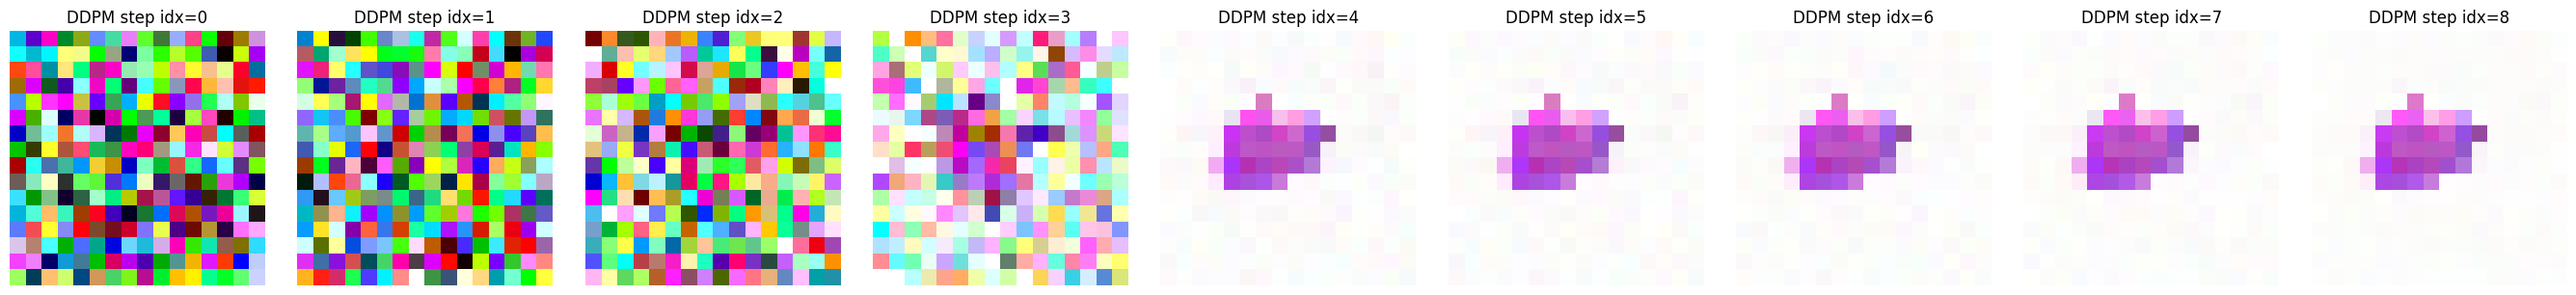

In [81]:
model = nn_model.eval()  # ensure in eval mode
batch_size = 1

final_ddpm, frames_ddpm = generate_samples_ddpm(model, batch_size=batch_size, 
                                                c=None, num_steps=timesteps,
                                                return_frames=True)

print(f"Collected {len(frames_ddpm)} frames during DDPM sampling.")

# Plot a subset of frames
num_plots = min(len(frames_ddpm), 10)
indices = np.linspace(0, len(frames_ddpm)-1, num_plots, dtype=int)

fig, axs = plt.subplots(1, num_plots, figsize=(3*num_plots, 3))
for i, idx in enumerate(indices):
    # frames_ddpm[idx]: shape (1, 3, H, W)
    img = frames_ddpm[idx].clone()
    
    # Convert from [-1,1] to [0,1] for plotting
    img = (img.clamp(-1,1) + 1) * 0.5  # shape still (1,3,H,W)
    
    axs[i].imshow( img[0].permute(1,2,0).numpy() )
    axs[i].set_title(f"DDPM step idx={idx}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


Collected 9 frames during DDIM sampling.


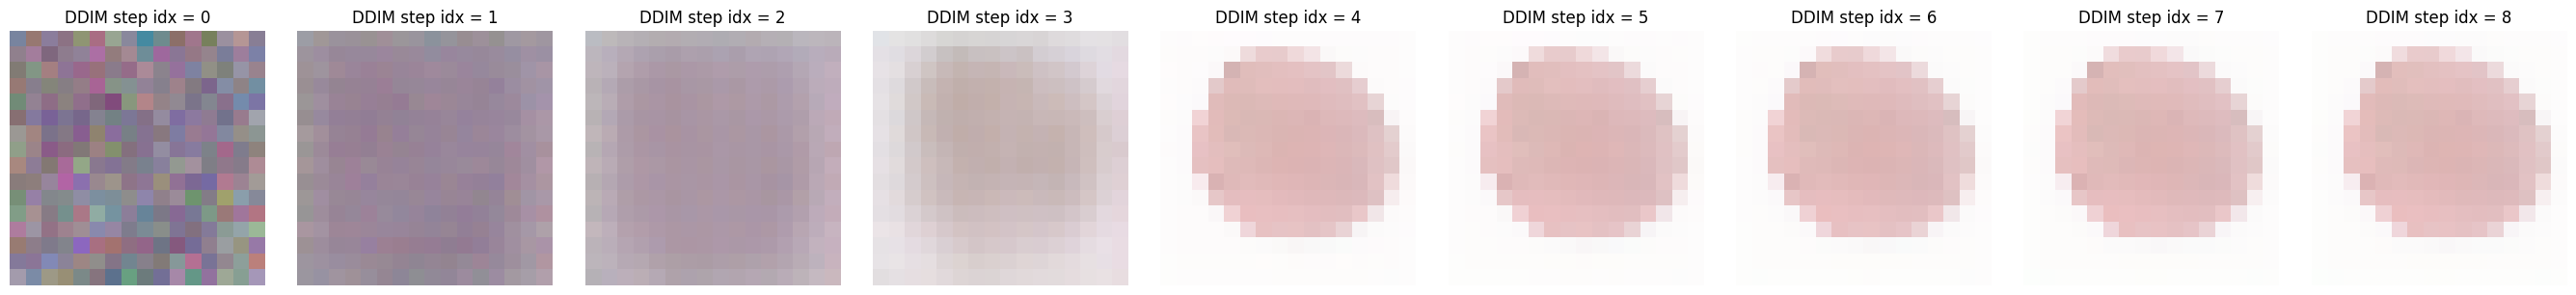

In [83]:
model = nn_model.eval()  # ensure eval mode
batch_size = 1

final_ddim, frames_ddim = generate_samples_ddim(
    model, 
    batch_size=batch_size, 
    c=None, 
    num_steps=timesteps, 
    eta=0.0,            # or another value > 0.0 for stochastic DDIM
    return_frames=True
)

print(f"Collected {len(frames_ddim)} frames during DDIM sampling.")

# Plot a subset of frames
num_plots = min(len(frames_ddim), 10)
indices = np.linspace(0, len(frames_ddim) - 1, num_plots, dtype=int)

fig, axs = plt.subplots(1, num_plots, figsize=(3 * num_plots, 3))
for i, idx in enumerate(indices):
    # frames_ddim[idx]: shape (1, 3, H, W)
    img = frames_ddim[idx].clone()
    
    # Convert from [-1, 1] => [0, 1] for plotting
    img = (img.clamp(-1, 1) + 1) * 0.5  # shape (1, 3, H, W)
    
    axs[i].imshow(img[0].permute(1, 2, 0).cpu().numpy())
    axs[i].set_title(f"DDIM step idx = {idx}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


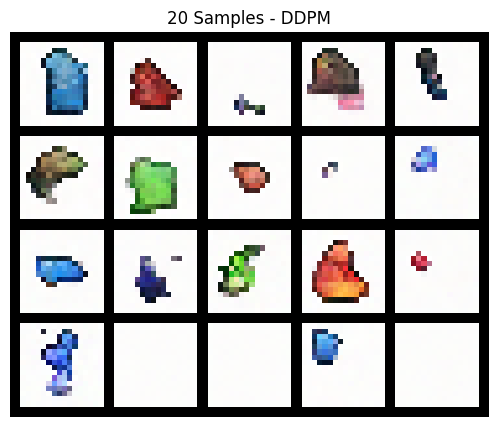

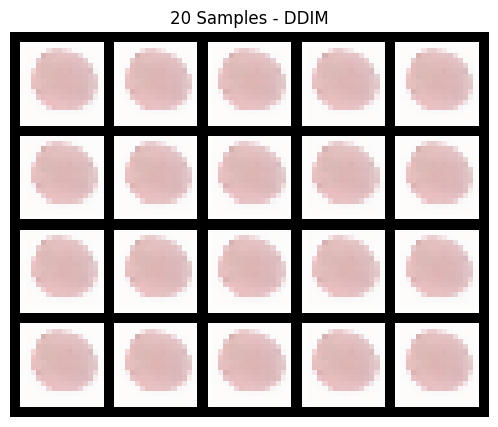

In [82]:
# Generate 20 samples via DDPM
ddpm_samples = generate_samples_ddpm(model, batch_size=20, c=None, 
                                     num_steps=timesteps, return_frames=False)
# Generate 20 samples via DDIM
ddim_samples = generate_samples_ddim(model, batch_size=20, c=None, 
                                     num_steps=timesteps, eta=0.0, 
                                     return_frames=False)

# Convert from [-1,1] => [0,1] for plotting
ddpm_samples_plot = (ddpm_samples.clamp(-1,1) + 1) * 0.5
ddim_samples_plot = (ddim_samples.clamp(-1,1) + 1) * 0.5

# Make grids
grid_ddpm = make_grid(ddpm_samples_plot, nrow=5)
grid_ddim = make_grid(ddim_samples_plot, nrow=5)

# Plot
plt.figure(figsize=(10,5))
plt.imshow(grid_ddpm.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.title("20 Samples - DDPM")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(grid_ddim.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.title("20 Samples - DDIM")
plt.show()


# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the FID score. 

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code. 

Installation

In [84]:
!pip install -qq pytorch-fid

Generate 3000 images by your model (by using either of generation processes) and save them in a directory. Also, save 3000 images from the sprites dataset and save them in another directory.

In [85]:
import os
import torch
import numpy as np
from torchvision.utils import save_image
from tqdm import trange
from pytorch_fid import fid_score
generated_dir = "./generated_images"
real_dir = "./real_images"

os.makedirs(generated_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)
model = nn_model.eval()  
num_to_generate = 3000
batch_size = 100
steps = timesteps  

counter = 0
while counter < num_to_generate:
    # Generate a mini-batch
    this_batch_size = min(batch_size, num_to_generate - counter)
    
    x_gen = generate_samples_ddpm(
        model, 
        batch_size=this_batch_size, 
        c=None,             
        num_steps=steps, 
        return_frames=False
    )
    # x_gen shape: (this_batch_size, 3, H, W) in [-1,1]

    # Map from [-1,1] -> [0,1]
    x_gen_01 = (x_gen.clamp(-1,1) + 1) * 0.5

    # Save each image
    for i in range(this_batch_size):
        img = x_gen_01[i]
        img_path = os.path.join(generated_dir, f"generated_{counter + i:04d}.png")
        save_image(img, img_path)
    
    counter += this_batch_size
    print(f"Generated {counter}/{num_to_generate} images")
num_real = 3000
counter = 0

real_loader = DataLoader(
    trian_dataset,  
    batch_size=100,
    shuffle=True,
    num_workers=1
)

for batch_idx, (images, _) in enumerate(real_loader):

    images_01 = (images.clamp(-1,1) + 1) * 0.5

    for i in range(images_01.size(0)):
        if counter >= num_real:
            break
        img = images_01[i]
        img_path = os.path.join(real_dir, f"real_{counter:04d}.png")
        save_image(img, img_path)
        counter += 1
    
    if counter >= num_real:
        break

print(f"Saved {num_real} real images to {real_dir}")
device_for_fid = 'cuda' if torch.cuda.is_available() else 'cpu'

fid_value = fid_score.calculate_fid_given_paths(
    [real_dir, generated_dir], 
    batch_size=50,      # Adjust based on memory
    device=device_for_fid, 
    dims=2048           # 2048 is default for Inception-v3
)

print("FID score = ", fid_value)


Generated 100/3000 images
Generated 200/3000 images
Generated 300/3000 images
Generated 400/3000 images
Generated 500/3000 images
Generated 600/3000 images
Generated 700/3000 images
Generated 800/3000 images
Generated 900/3000 images
Generated 1000/3000 images
Generated 1100/3000 images
Generated 1200/3000 images
Generated 1300/3000 images
Generated 1400/3000 images
Generated 1500/3000 images
Generated 1600/3000 images
Generated 1700/3000 images
Generated 1800/3000 images
Generated 1900/3000 images
Generated 2000/3000 images
Generated 2100/3000 images
Generated 2200/3000 images
Generated 2300/3000 images
Generated 2400/3000 images
Generated 2500/3000 images
Generated 2600/3000 images
Generated 2700/3000 images
Generated 2800/3000 images
Generated 2900/3000 images
Generated 3000/3000 images
Saved 3000 real images to ./real_images


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 109MB/s] 
100%|██████████| 60/60 [00:12<00:00,  4.92it/s]


FID score =  188.18802688947056
